In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt

In [89]:
LEARNING_RATE = 3e-4
EPOCHS = 5
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [90]:
train_data_df = pd.read_csv("data/train_data.csv")
test_data_df = pd.read_csv("data/test_data.csv")

In [91]:
train_data_df.drop(['Unnamed: 0', 'Y'], axis=1, inplace=True)
test_data_df.drop(['Unnamed: 0', 'Y'], axis=1, inplace=True)

In [92]:
train_data_tensor = torch.tensor(train_data_df.to_numpy(), dtype=float)
test_data_tensor = torch.tensor(test_data_df.to_numpy(), dtype=float)

In [93]:
train_data_tensor.shape, test_data_tensor.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

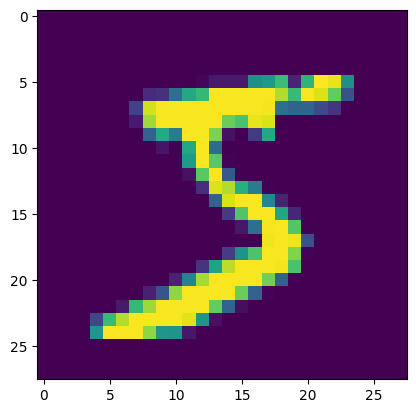

In [94]:
plt.imshow(train_data_tensor[0].view((28, 28)));

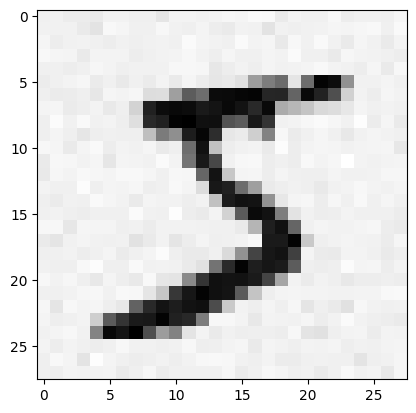

In [95]:
plt.imshow((train_data_tensor[0] + (10 * torch.randn_like(train_data_tensor[0]))).view((28, 28)), cmap='Greys')

In [96]:
class AutoEncoder(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        # encoder
        self.e1 = nn.Linear(in_dim, 256)
        self.norme1 = nn.BatchNorm1d(256)
        self.e2 = nn.Linear(256, 64)
        self.norme2 = nn.BatchNorm1d(64)
        self.e3 = nn.Linear(64, 8)
        self.norme3 = nn.BatchNorm1d(8)
        self.relu = nn.ReLU()

        # decoder
        self.d1 = nn.Linear(8, 64)
        self.normd1 = nn.BatchNorm1d(64)
        self.d2 = nn.Linear(64, 256)
        self.normd2 = nn.BatchNorm1d(256)
        self.d3 = nn.Linear(256, in_dim)
        self.normd3 = nn.BatchNorm1d(in_dim)

    def forward(self, x):
        x = self.norme1(self.e1(x))
        x = self.relu(x)
        x = self.norme2(self.e2(x))
        x = self.relu(x)
        x = self.norme3(self.e3(x))
        x = self.relu(x)

        x = self.normd1(self.d1(x))
        x = self.relu(x)
        x = self.normd2(self.d2(x))
        x = self.relu(x)
        x = self.normd3(self.d3(x))
        x = self.relu(x)

        return x

In [97]:
model = AutoEncoder(train_data_tensor.shape[1]).to(DEVICE)
optim = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [98]:
class MnistDataset(Dataset):
    def __init__(self, data):
        self.x = data + (10 * torch.randn_like(data))
        self.y = data

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [99]:
train_data = DataLoader(MnistDataset(train_data_tensor), batch_size=BATCH_SIZE, shuffle=True)
test_data = DataLoader(MnistDataset(test_data_tensor), batch_size=BATCH_SIZE, shuffle=True)

In [102]:
def train_epoch(model, train_data):
    lossi = []
    for x,y in train_data:
        x, y = x.to(DEVICE), y.to(DEVICE)
        output = model(x.float())
        loss = ((output - y) ** 2).mean()

        optim.zero_grad()
        loss.backward()
        optim.step()

        lossi.append(loss.item())
    
    print(lossi)
    return torch.tensor(lossi).mean()

In [ ]:
losses = []
for epoch in range(EPOCHS):
    loss = train_epoch(model, train_data)
    losses.append(loss.item())

    print(f"EPOCH: {epoch} | LOSS: {loss.item()}")

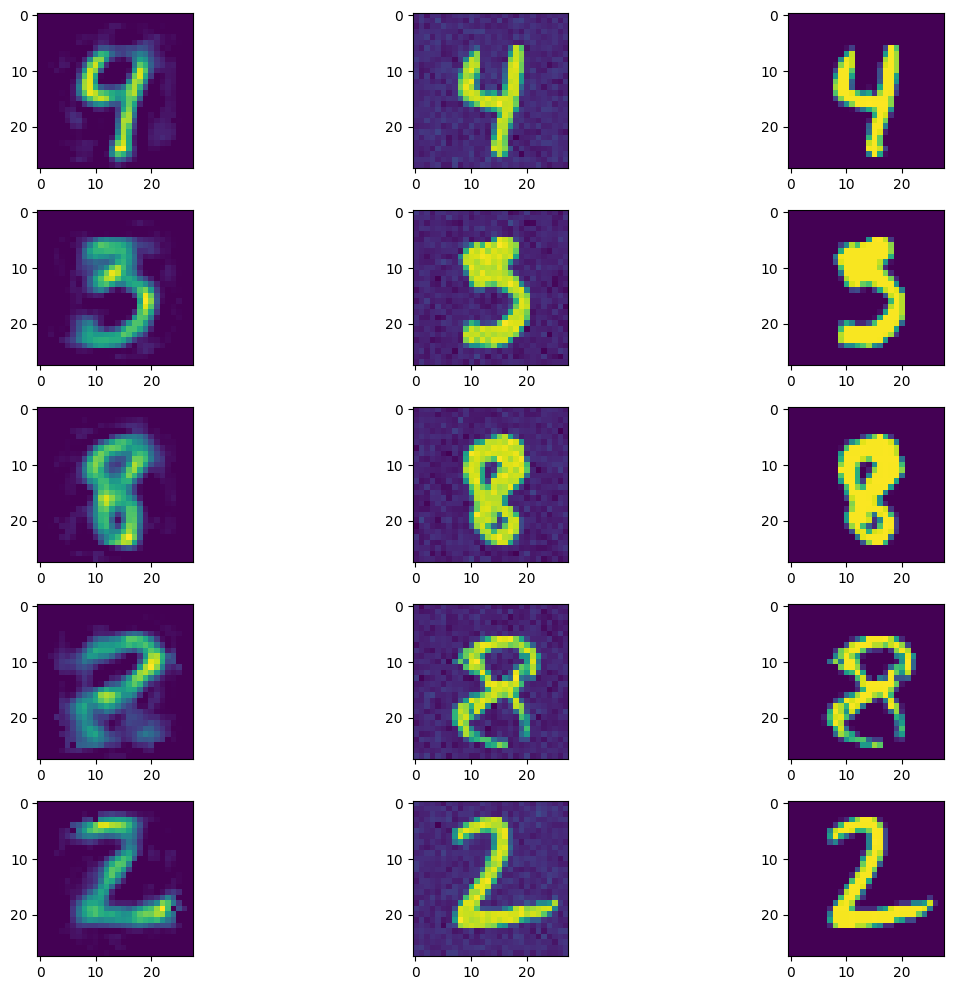

In [88]:
plt.figure(figsize=(14, 10))
c = 15
plots = 1
for i, (x,y) in enumerate(test_data):
    plt.subplot(c // 3, 3, plots)
    plt.imshow(model(x.float())[0].view((28, 28)).detach().numpy())
    plt.subplot(c // 3, 3, plots + 1)
    plt.imshow(x[0].view((28, 28)).detach().numpy())
    plt.subplot(c // 3, 3, plots + 2)
    plt.imshow(y[0].view((28, 28)).detach().numpy())
    plt.tight_layout()
    plots += 3
    if plots >= c:
        break